# Predict #
To be re-inserted into main Jupyter Notebook after.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For neural networks.
import keras as kr
# For data frames.
import pandas as pd
# For numerical arrays.
import numpy as np
# For preprocessing data.
import sklearn.preprocessing as pre
# For splitting data sets.
import sklearn.model_selection as mod
# For whitening.
import sklearn.decomposition as dec
# to write to csv file
import csv

Using TensorFlow backend.


In [2]:
# Import sklearn for comparison too
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset into a dataframe
data = pd.DataFrame(data = load_boston().data, columns= load_boston().feature_names)
# Add the house price
data["MEDV"] = load_boston().target
# Quick check that all is ok
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


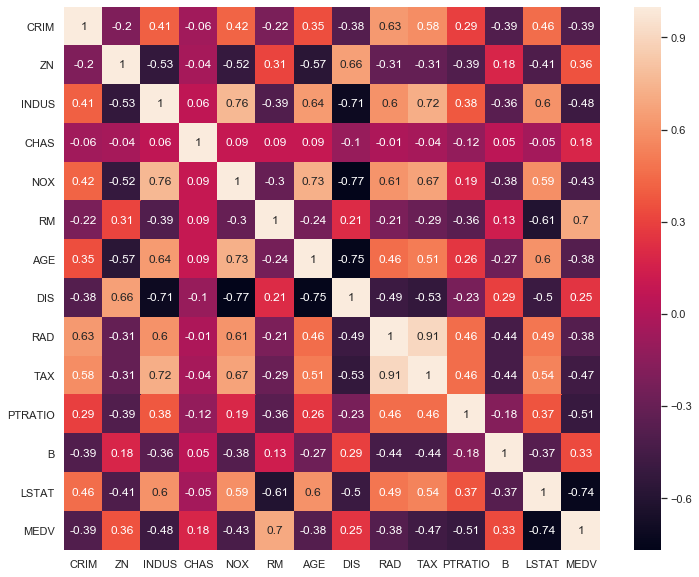

In [4]:
sns.set(rc={'figure.figsize':(12,10)})
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [5]:
# Let's look at the correlation matrix for MEDV
correlation_matrix["MEDV"]

CRIM      -0.39
ZN         0.36
INDUS     -0.48
CHAS       0.18
NOX       -0.43
RM         0.70
AGE       -0.38
DIS        0.25
RAD       -0.38
TAX       -0.47
PTRATIO   -0.51
B          0.33
LSTAT     -0.74
MEDV       1.00
Name: MEDV, dtype: float64

So to see what is the best number of parameters to use we will use the sledgehammer approach first. We will sort the parameters in order of the best correlation (positive or negative) and then check against increasing number of parameters to see which is the optimal.

In [6]:
# Sort the matrix in order of absolute correlation values 
cm = correlation_matrix.transform(func= lambda x: abs(x))["MEDV"].sort_values(ascending=False)
# Remove the MEDV value itself
cm = cm.drop("MEDV",axis=0)
# Show us the result
cm

LSTAT      0.74
RM         0.70
PTRATIO    0.51
INDUS      0.48
TAX        0.47
NOX        0.43
CRIM       0.39
RAD        0.38
AGE        0.38
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
Name: MEDV, dtype: float64

In [7]:
# Putting all possible parameters in a list in order of absolute correlation
params = []
for i in range(0, len(cm)):
    params.append(cm.index[i])

As we are using the sledgehammer approach - we will write a number of functions to perform the tasks required.

In [8]:
y = data['MEDV'] # outputs

# This function gets the inputs - this will depend on the number of parameters we are using in the model
def getInputs(noPar):
    # Split the dataset into what we are using
    return data[params[:noPar]] # inputs

In [9]:
# This function scales the inputs
def scaleDS(inputs):
    # Adding a scaler
    scaler = pre.StandardScaler()
    scaler.fit(inputs)
    return scaler.transform(inputs)

In [10]:
# This function whitens the inputs
def whiten(noAttrib, inputs):
    # Pre-component Analysis
    pca = dec.PCA(n_components=noAttrib, whiten=True)
    pca.fit(inputs)
    # Whiten the dataset
    inputs_white = pd.DataFrame(pca.transform(inputs), columns=inputs.columns)
    return inputs_white

Splitting the dataset into training and testing parts is recommended for checking your model. The split however can have an impact on how the model learns to predict the house prices. When we are comparing models it is good to take away this uncertainty so we are comparing against known differences between the models. To achieve this we use a parameter called seeded. If this is set to true the train / test split will be split using a repeatable seeded random state split which will divide the data repeatably.  

Conversely, if the seeded parameter is set to false there will be no seeding and there will be a random data split.

In [11]:
# This function splits the dataset into training and test data
# There is the option to apply a seed to the split too
def splitDS(inputs, seeded):
    # Make sure we are using the global paramters rather than creating local ones
    global x_train, x_test, y_train, y_test

    # Seed value used by the model random number generator
    seed = 7
    
    # if we are choosing to seed
    if seeded == True:
        # Split the dataset into training and testing with the random_state set
        x_train, x_test, y_train, y_test = mod.train_test_split(inputs, y, test_size=testSize, random_state=seed)
    else:
        # Split the dataset into training and testing without the random_state being set
        x_train, x_test, y_train, y_test = mod.train_test_split(inputs, y, test_size=testSize)

In [12]:
# This function creates the model with the specified activation type and optimiser
def createModel(actType, optType):
    
    # Making sure we are using the global parameters
    global noParams, noEpoch, batchSize
    
    # Create our model
    m = kr.models.Sequential()
    
    # Simple - no hidden layers
    m.add(kr.layers.Dense(20, input_dim=noParams, activation = actType))
    
    # Output layer - linear as it is a regression
    m.add(kr.layers.Dense(1, activation="linear"))
    
    # Defining our loss calculations
    m.compile(loss = "mean_squared_error", optimizer =optType)
    
    # Return the created model
    return m

In [13]:
# Use the model - specifying the model, the number of epochs, and the Batch Size
def doModel(model, epo, bs):
    # Ensuring we are using the global variables
    global x_train, x_test, y_tran, y_test, batchSize
    
    # Train the network
    model.fit(x_train, y_train, epochs=epo, batch_size=bs)
    
    # Evaluate the trained model using the test data
    # Calculate the loss function (Mean squared error in our case)
    return model.evaluate(x_test, y_test)

In [14]:
# Headings for the data
results= []

In [15]:
# Parameterise everything

# Do you want to create and test all the models? 
# If yes, set the following to true, if no, leave at false and data from previous run will be read into dataframe
yesCreateModels = False

# No of variables to include in predictions - it is reset later
noParams = 4 

# Test / Train Split - setting it to 30% being kept aside for evalaution / testing
testSize = 0.3

# All the activations
acts = ["relu", "tanh", "sigmoid", "exponential", "elu", "linear"]


# model trial settings
# Optimisers
opts= ["sgd", "adam", "nadam"] # Comparing three different optimisers
opt = opts[2] # This is set manually to stop break up the execution time below
noEpoch= 100
batchSize = 10

# Whether the data should be scaled or not
# This is also set manually due
pre_process = "scaled" # Pre-processing: raw, scaled or whitened 

if yesCreateModels == True:
    results= []
    # Check for increasing no of attributes and all activations
    for act in acts: 
        for noParams in range(1,13):
            print("Starting", act, "Parameter no:",noParams)
            # Create your inputs
            x = getInputs(noParams)
            # Scale if it is called for
            if pre_process  == "scaled":
                x_scaled = scaleDS(x)
            elif pre_process == "raw":
                x_scaled = x
            elif pre_process == "whitened":
                x_scaled = whiten(noParams, x)
            # Split into training and testing data with seeding so they are wll working on same split
            splitDS(x_scaled, True)
            # Create the model based on the parameters supplied
            m = createModel(act, opt)
            # Append the settings and final loss results after fitting and evaluating the model to the results file
            results.append([noParams, pre_process, testSize, act, opt, noEpoch, batchSize, doModel(m, noEpoch, batchSize)])

In [16]:
# Transfer all the data to a dataframe
if yesCreateModels == True:
    csvWriteType = "a" # "a" for append to add to existing csv, "w" to overwrite existing csv
    # Create a dataframe with the results and save it to a csv file if you don't want to go through the model generation in future
    columns = ["no_attrib", "pre_process", "test_size", "activation", "optimiser", "no_epochs", "batch_size", "loss"]
    tempdf = pd.DataFrame(results, columns=columns)
    tempdf.to_csv (r'data\results.csv', mode =csvWriteType, index = None, header=(csvWriteType == "w"), sep =",")

In [17]:
# If you didn't want to do the generation, read the csv file already prepared anyway
df = pd.read_csv(r"data\results.csv", error_bad_lines=False)

So now we have all the data in. For submission I have run the code for all optimisers with all pre-processing available each for three times. If you have run the code with the yesCreateModels bit set to True, the results may be different to those being discussed here. If you want to revert to the data as submitted uncomment out the code below to reload the data as submitted.

In [18]:
# Uncomment out the line below if you want to revert to the results at time of submission
#df = pd.read_csv(r"data\seeded_results.csv", error_bad_lines=False)

Obviously, with a brute force attack like the one we just performed, there will be a lot of scenarios tested that were particularly unsuited to the prediction of MEDV values. SO before we start to weed these out, lets look at the numbers we are starting with.

In [19]:
# The headers of our counts
preProcess = ["raw", "scaled", "whitened"]
hdrs = ["Event"] + preProcess + acts + opts + list(range(1,13))

# Create a blank dataframe to house the counts at various junctions
dfCounts = pd.DataFrame(columns = hdrs)

# Check all is good so far
dfCounts

,Event,raw,scaled,whitened,relu,tanh,sigmoid,exponential,elu,linear,...,3,4,5,6,7,8,9,10,11,12


In [20]:
# We will use this function to record the counts for every row
def countRows(df, eventName):
    #row = []
    row = [eventName]
    # Loop through each pre-processing type and do a count
    for process in preProcess:
        # If there are values, count them
        if process in df.pre_process.values: 
            row.append(df[df.pre_process == process].pre_process.value_counts().item())
        # Otherwise put a 0 in the count
        else:
            row.append(0)
    # Loop through each of the actiivations and do a count
    for act in acts:
        # If is exists, count
        if act in df.activation.values: 
            row.append(df[df.activation == act].activation.value_counts().item())
        # Otherwise add a zero
        else:
            row.append(0)
    # Loop through each of the optimisers and do a count
    for opt in opts:
        # If the optimiser is present, count
        if opt in df.optimiser.values: 
            row.append(df[df.optimiser == opt].optimiser.value_counts().item())
        # If not, add a zero
        else:
            row.append(0)
    # For all the numbers of attributes
    for p in list(range(1,13)):
        # If it is present, count it
        if p in df.no_attrib.values: 
            row.append(df[df.no_attrib == p].no_attrib.value_counts().item())
        # Otherwise add a zero
        else:
            row.append(0)  
    # Put all the values in a dictionary with the headings [20]
    dictionary = dict(zip(hdrs, row))
    # Return the dictionary as a dataframe    
    return pd.DataFrame(dictionary, columns =hdrs, index =[0]) 

In [21]:
# So let's take a snapshot of counts at the start
dfCounts = dfCounts.append(countRows(df,"Start"),ignore_index=True)
dfCounts

,Event,raw,scaled,whitened,relu,tanh,sigmoid,exponential,elu,linear,...,3,4,5,6,7,8,9,10,11,12
0,Start,648,648,648,324,324,324,324,324,324,...,162,162,162,162,162,162,162,162,162,162


In [22]:
# Drop all rows that have no loss results
drop_rows = df.index[df["loss"].isnull()]
df.drop(drop_rows, axis=0, inplace=True)
dfCounts = dfCounts.append(countRows(df,"No NaNs"),ignore_index=True)
dfCounts

,Event,raw,scaled,whitened,relu,tanh,sigmoid,exponential,elu,linear,...,3,4,5,6,7,8,9,10,11,12
0,Start,648,648,648,324,324,324,324,324,324,...,162,162,162,162,162,162,162,162,162,162
1,No NaNs,506,614,615,322,324,324,166,311,288,...,148,142,144,144,143,143,141,142,140,143


In [23]:
df.describe()

,no_attrib,test_size,no_epochs,batch_size,loss
count,1735.000000,1.735000e+03,1735.0,1735.0,1.735000e+03
mean,6.421326,3.000000e-01,100.0,10.0,1.740634e+20
std,3.472998,7.163003e-15,0.0,0.0,7.250320e+21
min,1.000000,3.000000e-01,100.0,10.0,1.086954e+01
25%,3.000000,3.000000e-01,100.0,10.0,2.105450e+01
50%,6.000000,3.000000e-01,100.0,10.0,2.753407e+01
75%,9.000000,3.000000e-01,100.0,10.0,3.425916e+01
max,12.000000,3.000000e-01,100.0,10.0,3.020000e+23


As can be seen in the describe results above, there is a massive variation in loss results from around 11 to 3 x 10$^{23}$. These values are hugely skewed with 75% of all results below 35, yet the mean is 1.7 x 10$^{20}$!. Lets remove that top 25%, and do so repeatedly until the loss is more reasonable - say under 15.

In [24]:
# Drop all rows that have loss over the 75 percentile [21] repeatedly until max loss value is under 15
while df.loss.max() > 15:
    drop_rows = df.index[df["loss"]>np.percentile(df.loss, 75, axis=0)]
    df.drop(drop_rows, axis=0, inplace=True)
    # See what this has done to the rows
    dfCounts = dfCounts.append(countRows(df,"Remove Values over 75%"),ignore_index=True)
dfCounts

,Event,raw,scaled,whitened,relu,tanh,sigmoid,exponential,elu,linear,...,3,4,5,6,7,8,9,10,11,12
0,Start,648,648,648,324,324,324,324,324,324,...,162,162,162,162,162,162,162,162,162,162
1,No NaNs,506,614,615,322,324,324,166,311,288,...,148,142,144,144,143,143,141,142,140,143
2,Remove Values over 75%,156,575,570,256,223,221,130,267,204,...,124,120,106,104,105,100,106,107,104,110
3,Remove Values over 75%,74,451,451,229,197,153,125,237,35,...,87,87,74,80,78,75,83,79,83,101
4,Remove Values over 75%,19,355,358,180,157,123,89,182,1,...,66,71,67,69,68,66,68,73,69,74
5,Remove Values over 75%,1,284,264,149,105,88,63,144,0,...,23,44,55,58,56,58,60,68,58,67
6,Remove Values over 75%,0,205,207,118,90,59,41,104,0,...,3,22,46,45,44,44,48,56,42,62
7,Remove Values over 75%,0,161,148,75,76,48,28,82,0,...,0,4,33,32,34,34,37,44,37,54
8,Remove Values over 75%,0,125,107,48,60,47,15,62,0,...,0,0,24,24,23,25,28,33,31,44
9,Remove Values over 75%,0,95,79,29,45,41,9,50,0,...,0,0,18,17,15,18,19,25,24,38


In [25]:
# Look at the dataframe transposed to get a full look at the dataset
dfCounts.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12
Event,Start,No NaNs,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%,Remove Values over 75%
raw,648,506,156,74,19,1,0,0,0,0,0,0,0
scaled,648,614,575,451,355,284,205,161,125,95,67,48,39
whitened,648,615,570,451,358,264,207,148,107,79,63,49,34
relu,324,322,256,229,180,149,118,75,48,29,20,17,13
tanh,324,324,223,197,157,105,90,76,60,45,33,27,24
sigmoid,324,324,221,153,123,88,59,48,47,41,33,21,14
exponential,324,166,130,125,89,63,41,28,15,9,8,6,5
elu,324,311,267,237,182,144,104,82,62,50,36,26,17
linear,324,288,204,35,1,0,0,0,0,0,0,0,0


Well that has gotten rid of most of the data! There are suddenly no raw values at all, no values with a linear activation, and no values where the model is using less than 5 variables!  

So what does that leave us with? Let's plot them out.

Text(0.5, 1.0, 'Performance of Different Activations Using Various Number of Attributes')

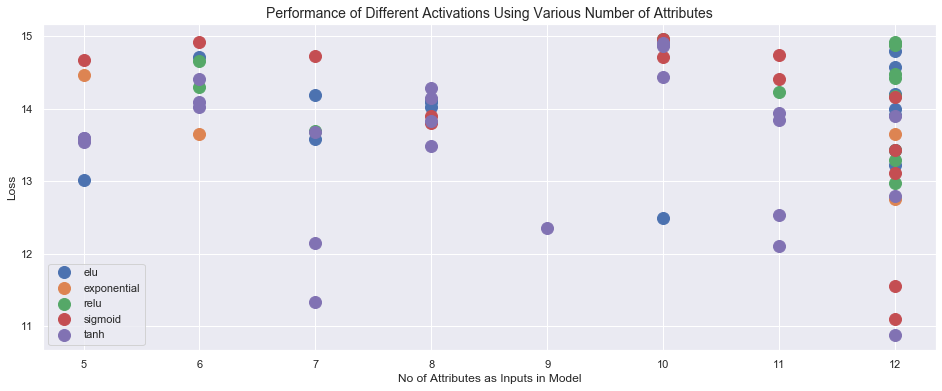

In [26]:
# Plot the actvations to see which performed best
plt.rcParams["figure.figsize"] = [16, 6]

# Group the data by activation
groups = df.groupby(["activation"])

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# For each activation group, plot the loss vs no of attributes used
for activation, group in groups:
    ax.plot(group["no_attrib"], group["loss"], "o", ms=12, label=activation)
    
# Add the legend
ax.legend()
# And labels and titles
ax.set_ylabel("Loss")
ax.set_xlabel("No of Attributes as Inputs in Model")
plt.title("Performance of Different Activations Using Various Number of Attributes", fontsize = 14)

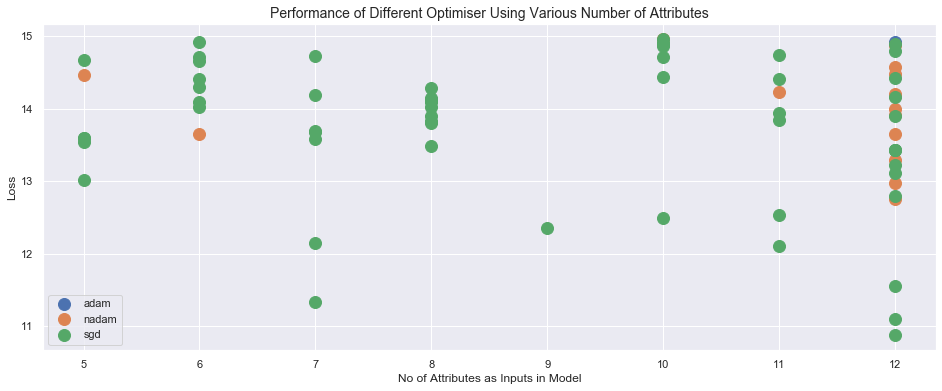

In [27]:
# A quick check to see there was more than one optimiser used. 
# This would not be the case if the user didn not append to existing results fil
if len(df.optimiser.unique()) >1:
    # Plot the actvations to see which performed best
    plt.rcParams["figure.figsize"] = [16, 6]
    # Group the data by the optimiser
    groups = df.groupby('optimiser')

    # Plot
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for optimiser, group in groups:
        # For each optimiser  plot the no of attobutes used in the model against the loss
        ax.plot(group["no_attrib"], group["loss"], "o", ms=12, label=optimiser)
    
    # Add legend, labels and title
    ax.legend()
    ax.set_ylabel("Loss")
    ax.set_xlabel("No of Attributes as Inputs in Model")
    plt.title("Performance of Different Optimiser Using Various Number of Attributes", fontsize = 14)
else:
    # Otherwise print a message
    print("Only one optimiser used")

That doesn't tell us much.Lets try some boxplots instead.

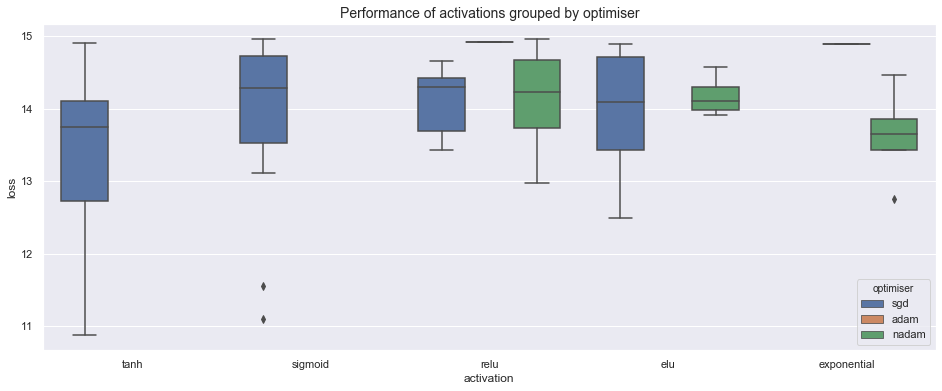

In [28]:
# PLot of activations against loss grouped by optimiser
# First need to check if there is more than one optimiser in the dataset
if len(df.optimiser.unique())>1:
    # Do the boplot
    sns.boxplot(x = "activation", y = "loss", hue = "optimiser", data = df)
    # And title
    plt.title("Performance of activations grouped by optimiser", fontsize = 14)
# Otherwise just print a message
else:
    print("Only one optimiser used")

In this plot we can see that the sigmoid gradient descent optimiser had the best overall performance, follwed by nadam and finally adam.  

From an activation, the tanh activation proved to be the best.

Text(0.5, 1.0, 'Performance of Activations Grouped by Pre-Processing Technique')

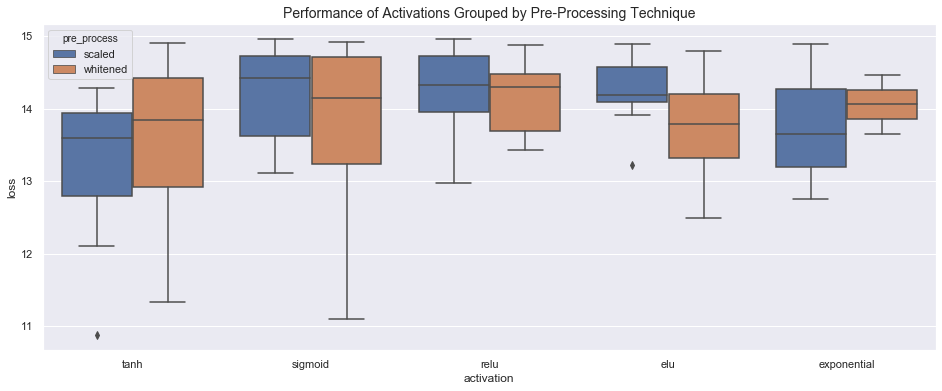

In [29]:
# Boxplot of Activations grouped by Pre-Processing technique
sns.boxplot(x = "activation", y = "loss", hue = "pre_process", data = df)
plt.title("Performance of Activations Grouped by Pre-Processing Technique",fontsize = 14)

Looking at the pre-processing techniques on the activations, in general we can say that whitening proved more capable than scaled but with a good deal of overlap. Tanh activation proved to be the best activation particularly for scaled values.

Text(0.5, 1.0, 'Performance of No of Attributes Grouped by Optimiser')

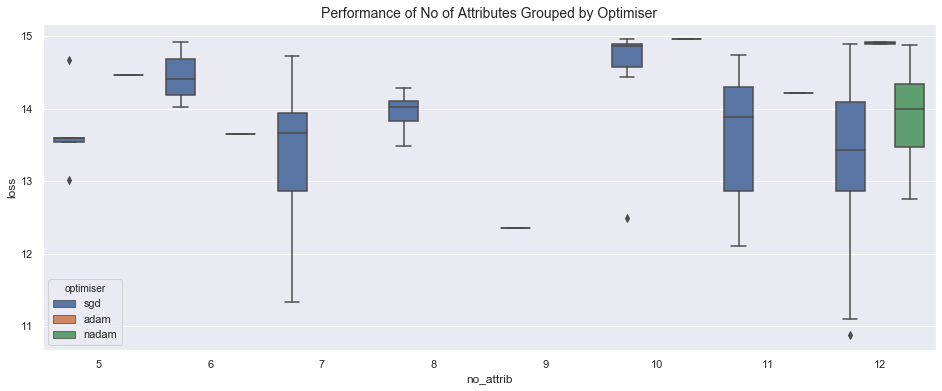

In [30]:
# Boxplot of Opt
sns.boxplot(x = "no_attrib", y = "loss", hue = "optimiser", data = df)
plt.title("Performance of No of Attributes Grouped by Optimiser",fontsize = 14)

Here we can see the sgd optimiser the clear winner, producing the most results over the greatest range of attribute values.

Text(0.5, 1.0, 'Performance of No of Attributes Grouped by Activations')

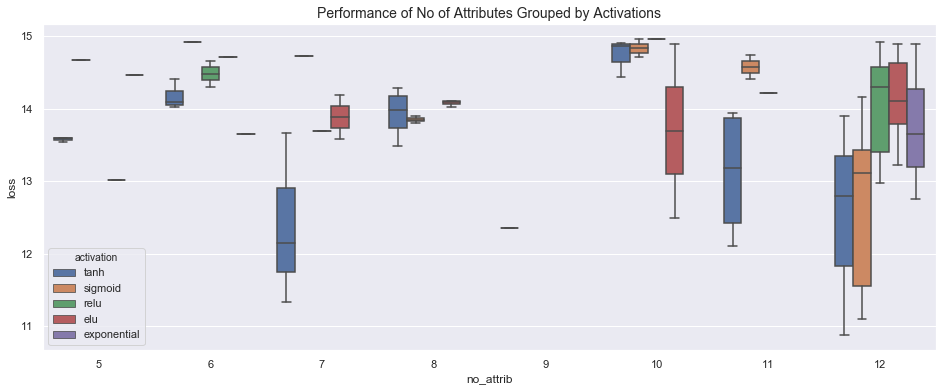

In [31]:
# Comparing the Activations with number of attributes
sns.boxplot(x = "no_attrib", y = "loss", hue = "activation", data = df)
plt.title("Performance of No of Attributes Grouped by Activations",fontsize = 14)

There is interesting variation in the activations. The tanh appears to be the most consistent throughout, but the sigmoid comes into its own with increasing attribute numbers in the model.

Let's look at the top five best loss results  - individually and as an average of all their three readings.

In [32]:
# The top 5 individual model iterations according to loss
df.sort_values(by='loss', ascending=True).head(5)

,no_attrib,pre_process,test_size,activation,optimiser,no_epochs,batch_size,loss
815,12,scaled,0.3,tanh,sgd,100,10,10.869543
1403,12,whitened,0.3,sigmoid,sgd,100,10,11.102258
1386,7,whitened,0.3,tanh,sgd,100,10,11.331125
1259,12,whitened,0.3,sigmoid,sgd,100,10,11.558590
814,11,scaled,0.3,tanh,sgd,100,10,12.099381


In [33]:
# The top 5 based on averages
df[["no_attrib", "pre_process", "activation", "optimiser", "loss"]].groupby(["no_attrib", "pre_process", "activation", "optimiser"]).mean().sort_values(by='loss', ascending=True).head(5)

,,,,loss
no_attrib,pre_process,activation,optimiser,
12,whitened,sigmoid,sgd,11.330424
7,whitened,tanh,sgd,11.740958
9,whitened,tanh,sgd,12.355279
10,whitened,elu,sgd,12.495919
12,scaled,tanh,sgd,12.517855


In [34]:
from tensorflow.keras.callbacks import EarlyStopping


# Test / Train Split - setting it to 30% being kept aside for evalaution / testing
testSize = 0.3
noEpoch= 200
batchSize = 10

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 1,
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)
# Model 1
noParams = 13
pre_process = "whitened"
act = "sigmoid"
opt = "sgd"

# Create our model
m1 = kr.models.Sequential()
    
# Increasing units and adding a hiden layer
m1.add(kr.layers.Dense(50, input_dim=noParams, activation = "tanh"))
m1.add(kr.layers.Dense(25, activation = "softplus"))
# Output layer - linear as it is a regression
m1.add(kr.layers.Dense(1, activation="linear"))
    
# Defining our loss calculations
m1.compile(loss = "mean_absolute_error", optimizer ="adam", metrics=['mse'])

x = getInputs(noParams)
# Scale if it is called for
if pre_process  == "scaled":
    x_scaled = scaleDS(x)
elif pre_process == "raw":
    x_scaled = x
elif pre_process == "whitened":
    x_scaled = whiten(noParams, x)
# Split into training and testing data with seeding so they are wll working on same split
splitDS(x_scaled, False)

# Train the model
history = m1.fit(x_scaled, y, validation_split=0.33, epochs=noEpoch, batch_size=batchSize)#, callbacks = [earlystop])
    
    # Train the network
    
    # Evaluate the trained model using the test data
    # Calculate the loss function (Mean squared error in our case)
    #return model.evaluate(x_test, y_test)

Train on 339 samples, validate on 167 samples
Epoch 1/200
339/339 [==============================] - 1s 1ms/step - loss: 25.8782 - mse: 743.3326 - val_loss: 18.2901 - val_mse: 398.1535
Epoch 2/200
339/339 [==============================] - 0s 238us/step - loss: 24.4435 - mse: 671.7157 - val_loss: 18.0574 - val_mse: 388.0266
Epoch 3/200
339/339 [==============================] - 0s 197us/step - loss: 22.4804 - mse: 581.6230 - val_loss: 17.8538 - val_mse: 380.7220
Epoch 4/200
339/339 [==============================] - 0s 220us/step - loss: 19.2393 - mse: 448.3346 - val_loss: 17.5193 - val_mse: 373.0233
Epoch 5/200
339/339 [==============================] - 0s 211us/step - loss: 13.4101 - mse: 264.2078 - val_loss: 16.8169 - val_mse: 363.4630
Epoch 6/200
339/339 [==============================] - 0s 194us/step - loss: 7.2511 - mse: 110.4532 - val_loss: 16.4554 - val_mse: 359.0478
Epoch 7/200
339/339 [==============================] - 0s 217us/step - loss: 4.7229 - mse: 49.0422 - val_loss: 

339/339 [==============================] - 0s 208us/step - loss: 1.8410 - mse: 6.9818 - val_loss: 10.5476 - val_mse: 178.6151
Epoch 60/200
339/339 [==============================] - 0s 241us/step - loss: 1.8587 - mse: 6.9360 - val_loss: 10.4569 - val_mse: 177.2867
Epoch 61/200
339/339 [==============================] - 0s 217us/step - loss: 1.8209 - mse: 6.5486 - val_loss: 10.3978 - val_mse: 175.6347
Epoch 62/200
339/339 [==============================] - 0s 223us/step - loss: 1.8134 - mse: 6.5028 - val_loss: 10.4563 - val_mse: 175.7952
Epoch 63/200
339/339 [==============================] - 0s 170us/step - loss: 1.7981 - mse: 6.3308 - val_loss: 10.2485 - val_mse: 171.8904
Epoch 64/200
339/339 [==============================] - 0s 223us/step - loss: 1.7850 - mse: 6.2983 - val_loss: 10.2954 - val_mse: 171.1448
Epoch 65/200
339/339 [==============================] - 0s 182us/step - loss: 1.8309 - mse: 6.5056 - val_loss: 10.2283 - val_mse: 169.9955
Epoch 66/200
339/339 [==================

339/339 [==============================] - 0s 236us/step - loss: 1.2305 - mse: 3.2084 - val_loss: 8.7765 - val_mse: 138.3684
Epoch 119/200
339/339 [==============================] - 0s 197us/step - loss: 1.2031 - mse: 3.1198 - val_loss: 8.7761 - val_mse: 138.2641
Epoch 120/200
339/339 [==============================] - 0s 188us/step - loss: 1.2157 - mse: 3.1506 - val_loss: 8.7239 - val_mse: 136.1420
Epoch 121/200
339/339 [==============================] - 0s 161us/step - loss: 1.2114 - mse: 3.1284 - val_loss: 8.7575 - val_mse: 138.2750
Epoch 122/200
339/339 [==============================] - 0s 188us/step - loss: 1.1633 - mse: 3.0037 - val_loss: 8.7320 - val_mse: 136.9305
Epoch 123/200
339/339 [==============================] - 0s 176us/step - loss: 1.2000 - mse: 3.0726 - val_loss: 8.6283 - val_mse: 134.5762
Epoch 124/200
339/339 [==============================] - 0s 179us/step - loss: 1.2118 - mse: 3.1719 - val_loss: 8.6304 - val_mse: 133.8650
Epoch 125/200
339/339 [==================

Epoch 177/200
339/339 [==============================] - 0s 169us/step - loss: 1.0204 - mse: 2.3240 - val_loss: 8.2906 - val_mse: 129.4185
Epoch 178/200
339/339 [==============================] - 0s 179us/step - loss: 1.0772 - mse: 2.4289 - val_loss: 8.2841 - val_mse: 131.4422
Epoch 179/200
339/339 [==============================] - 0s 159us/step - loss: 1.0522 - mse: 2.3859 - val_loss: 8.3000 - val_mse: 130.2229
Epoch 180/200
339/339 [==============================] - 0s 179us/step - loss: 1.0044 - mse: 2.2749 - val_loss: 8.2645 - val_mse: 129.2209
Epoch 181/200
339/339 [==============================] - 0s 173us/step - loss: 1.0107 - mse: 2.2921 - val_loss: 8.2608 - val_mse: 130.2445
Epoch 182/200
339/339 [==============================] - 0s 171us/step - loss: 1.0336 - mse: 2.3609 - val_loss: 8.2590 - val_mse: 128.7154
Epoch 183/200
339/339 [==============================] - 0s 156us/step - loss: 1.0597 - mse: 2.4242 - val_loss: 8.3736 - val_mse: 131.0688
Epoch 184/200
339/339 [====

In [35]:
m1.evaluate(x_test,y_test)

152/152 [==============================] - 0s 45us/step


[4.161984506406282, 59.403961181640625]

In [36]:
pred1 = m1.predict(x_test)

In [37]:
predt1 = m1.predict(x_train)

In [38]:
from sklearn import metrics
score = np.sqrt(metrics.mean_squared_error(pred1, y_test))
score

7.707396542049234

In [39]:
scoret = np.sqrt(metrics.mean_squared_error(predt1, y_train))
scoret

6.178764486744125

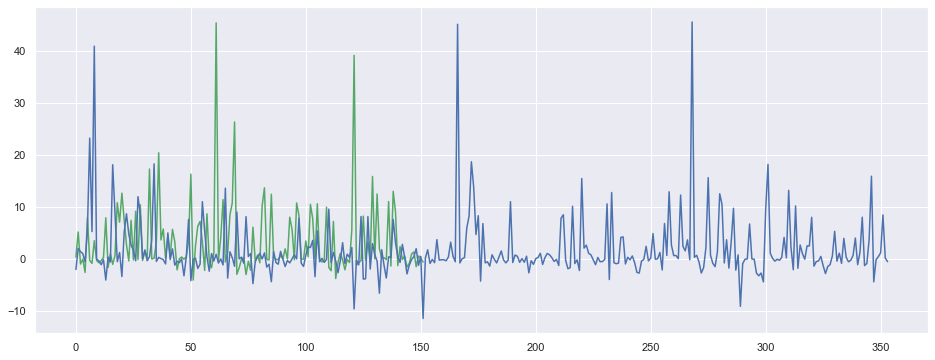

In [40]:
var1=[]
var2=[]
i = 0
for val in y_test:
    try:
        var1.append(val - pred1[i])
    except:
        pass
    i+=1
i = 0
for val in y_train:
    try:
        var2.append(val - predt1[i])
    except:
        pass
    i+=1
plt.plot(var1, "g-")
plt.plot(var2, "b-")
    

In [41]:
# Test / Train Split - setting it to 30% being kept aside for evalaution / testing
testSize = 0.3
noEpoch= 200
batchSize = 10

# Model 1
noParams = 13
pre_process = "whitened"
act = "sigmoid"
opt = "sgd"

x = getInputs(noParams)
scaler = pre.MinMaxScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=params[:noParams])
x_scaled = whiten(noParams,x_scaled)
# This function scales the inputs
def scaleDS(inputs):
    # Adding a scaler
    scaler = pre.StandardScaler()
    scaler.fit(inputs)
    return scaler.transform(inputs)

In [42]:
# create model
model = kr.models.Sequential()
model.add(kr.layers.Dense(150, input_dim=noParams, activation="relu"))
model.add(kr.layers.Dense(75, activation="relu"))
model.add(kr.layers.Dense(1, activation="linear"))

In [43]:
# Compile model
model.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 150)               2100      
_________________________________________________________________
dense_5 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 76        
Total params: 13,501
Trainable params: 13,501
Non-trainable params: 0
_________________________________________________________________


dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])


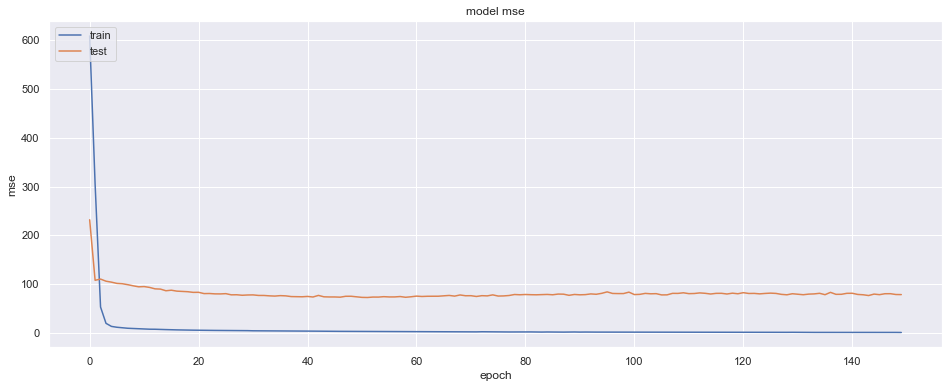

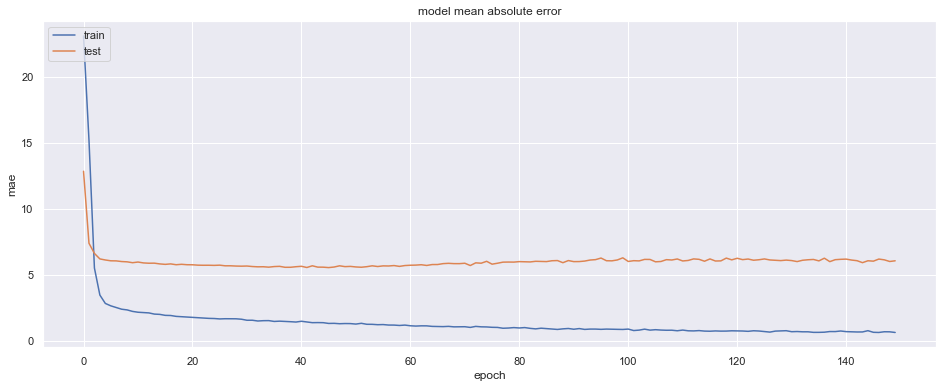

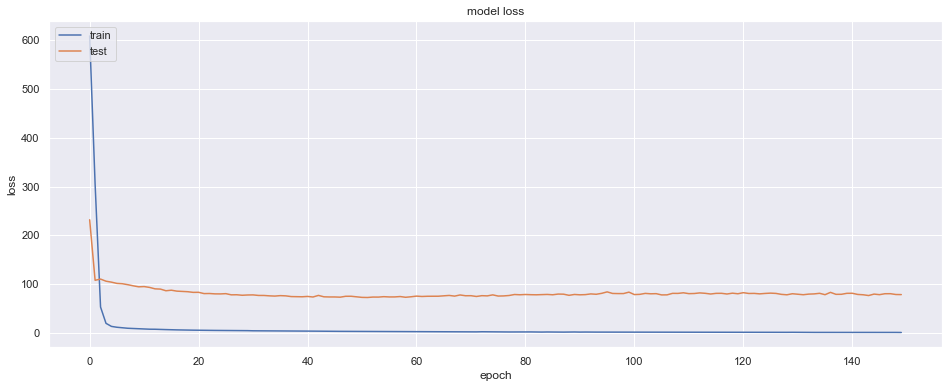

In [44]:
# Fit the model
history = model.fit(x_scaled, y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
# Test / Train Split - setting it to 30% being kept aside for evalaution / testing
testSize = 0.3
noEpoch= 200
batchSize = 10

# Model 1
noParams = 13
pre_process = "scaled"
act = "sigmoid"
opt = "sgd"


x = getInputs(noParams)
# Scale if it is called for
if pre_process  == "scaled":
    x_scaled = scaleDS(x)
elif pre_process == "raw":
    x_scaled = x
elif pre_process == "whitened":
    x_scaled = whiten(noParams, x)

# create model
model = kr.models.Sequential()
model.add(kr.layers.Dense(150, input_dim=noParams, activation="relu"))
model.add(kr.layers.Dense(75, activation="relu"))
model.add(kr.layers.Dense(1, activation="linear"))
# Compile model
model.compile(loss= "mse", optimizer="adam", metrics=["mse", "mae"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 150)               2100      
_________________________________________________________________
dense_8 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 76        
Total params: 13,501
Trainable params: 13,501
Non-trainable params: 0
_________________________________________________________________


dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])


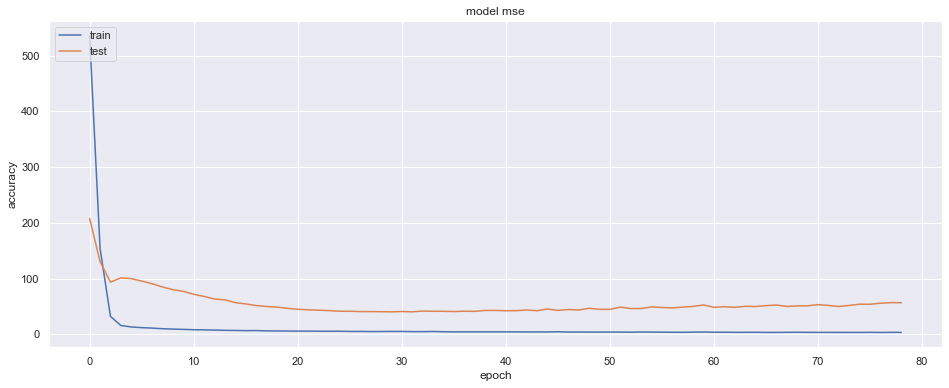

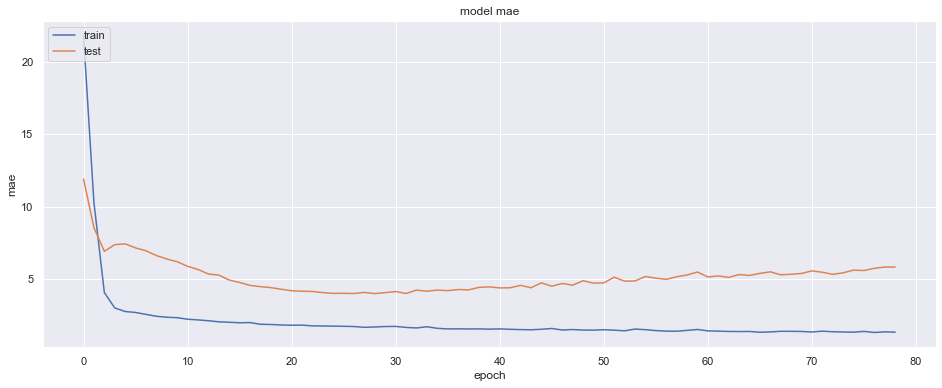

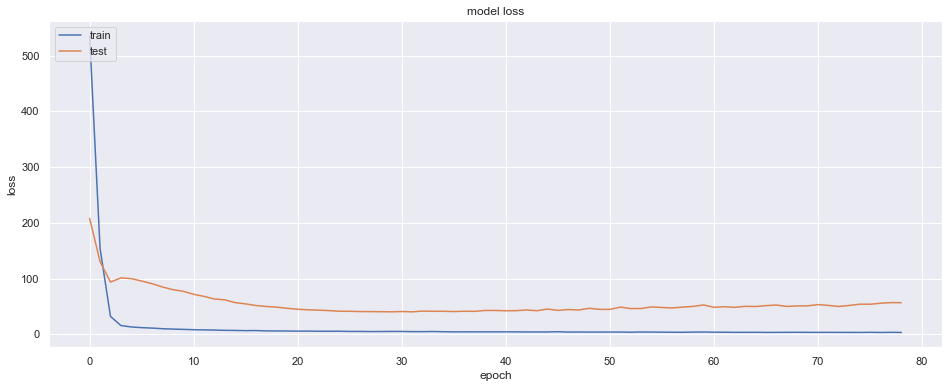

In [46]:
import keras
earlystop = keras.callbacks.EarlyStopping(monitor="val_mae", patience = 50)

# Fit the model
history = model.fit(x_scaled, y, validation_split=0.33, epochs=500, batch_size=10, verbose=0, callbacks = [earlystop])
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']